# 09. 모델의 효율성 판단

In [31]:
library(tidyverse)
library(tidymodels)
ggplot2::theme_set(theme_bw())
tidymodels_prefer()

In [37]:
data(ames)
ames <- mutate(ames, Sale_Price = log10(Sale_Price))

In [38]:
set.seed(502)
ames_split <- initial_split(ames, prop = 0.80, strata = Sale_Price)
ames_train <- training(ames_split)
ames_test  <-  testing(ames_split)

# 
# 
## 회귀 모델 평가 척도

In [55]:
ames_rec <- 
  recipe(Sale_Price ~ Neighborhood + Gr_Liv_Area + Year_Built + Bldg_Type + 
           Latitude + Longitude, data = ames_train) %>%
  step_log(Gr_Liv_Area, base = 10) %>% 
  step_other(Neighborhood, threshold = 0.01) %>% 
  step_dummy(all_nominal_predictors()) %>% 
  step_interact( ~ Gr_Liv_Area:starts_with("Bldg_Type_") ) %>% 
  step_ns(Latitude, Longitude, deg_free = 20)

In [56]:
lm_model <- linear_reg() %>% set_engine("lm")

In [57]:
lm_wflow <- 
  workflow() %>% 
  add_model(lm_model) %>% 
  add_recipe(ames_rec)

In [58]:
lm_fit <- fit(lm_wflow, ames_train)

In [59]:
ames_test_res <- predict(lm_fit, new_data = ames_test %>% select(-Sale_Price))
ames_test_res <- bind_cols(ames_test_res, ames_test %>% select(Sale_Price))
ames_test_res %>% head()

.pred,Sale_Price
<dbl>,<dbl>
5.068004,5.021189
5.308006,5.387390
5.283059,5.278525
5.334702,5.282169
5.300226,5.276462
5.244411,5.256237


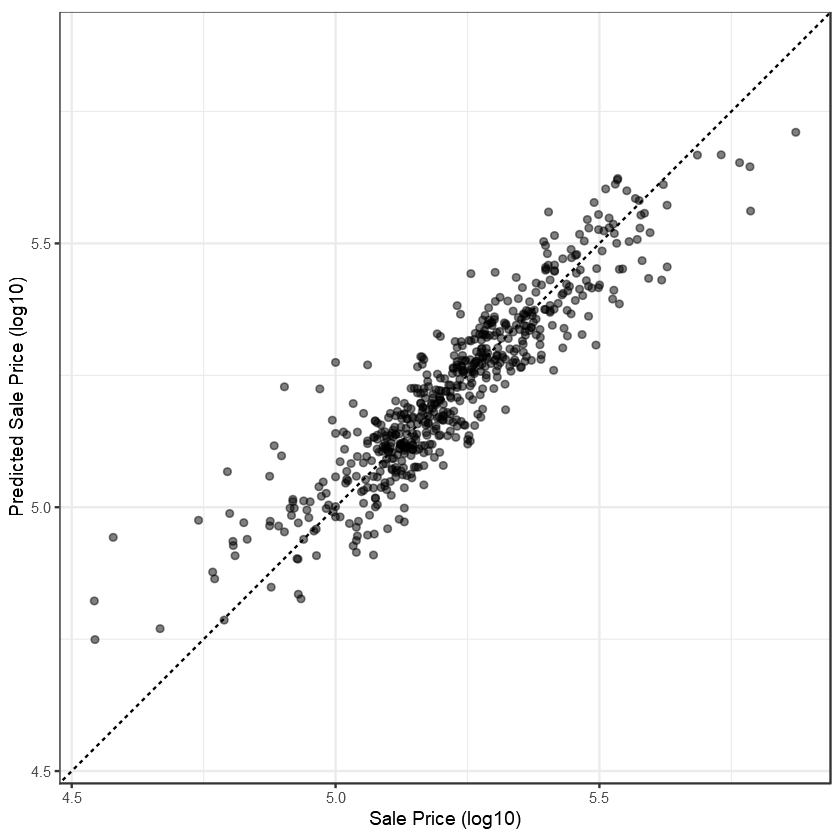

In [53]:
ggplot(ames_test_res, aes(x = Sale_Price, y = .pred)) + 
    geom_abline(lty = 2) + 
    geom_point(alpha = 0.5) + 
    labs(y = "Predicted Sale Price (log10)", x = "Sale Price (log10)") +
    coord_obs_pred()

# 
# 
# 
### ```rmse()``` : RMSE
### ```rsq()``` : R^2
### ```mae()``` : MAE

# 

### ```metric_set()``` : 평가 척도 지정

In [65]:
ames_metrics <- metric_set(rmse, rsq, mae)
ames_metrics(ames_test_res, truth = Sale_Price, estimate = .pred)

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,0.07362974
rsq,standard,0.83593999
mae,standard,0.05488583


# 
# 
# 
## 이진 분류 평가 척도

### ```conf_mat()``` : 혼동행렬
### ```accuracy()``` : 정확도
### ```mcc()``` : Mattews correlation coefficient (벡터간 상관계수)
https://ivoryrabbit.github.io/%EC%88%98%ED%95%99/2021/03/12/%EB%A7%A4%ED%8A%9C-%EC%83%81%EA%B4%80%EA%B3%84%EC%88%98.html

### ```f_meas``` : F1-score

# 

- Matthews 상관 계수와 F1 점수는 모두 혼동 행렬을 요약하지만, **Positive와 Negative 모두의 품질을 측정하는 ```mcc()``` 에 비해, ```f_meas()``` 는 관심 있는 이벤트인 Positive Class를 강조**

# 
# 

In [78]:
two_class_example %>% glimpse

Rows: 500
Columns: 4
$ truth     <fct> Class2, Class1, Class2, Class1, Class2, Class1, Class1, Clas~
$ Class1    <dbl> 0.0035892426, 0.6786210540, 0.1108935221, 0.7351617031, 0.01~
$ Class2    <dbl> 9.964108e-01, 3.213789e-01, 8.891065e-01, 2.648383e-01, 9.83~
$ predicted <fct> Class2, Class1, Class2, Class1, Class2, Class1, Class1, Clas~


In [69]:
conf_mat(two_class_example, truth = truth, estimate = predicted)
accuracy(two_class_example, truth, predicted)
mcc(two_class_example, truth, predicted)
f_meas(two_class_example, truth, predicted)

          Truth
Prediction Class1 Class2
    Class1    227     50
    Class2     31    192

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.838


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
mcc,binary,0.6768476


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
f_meas,binary,0.8485981


In [70]:
classification_metrics <- metric_set(accuracy, mcc, f_meas)
classification_metrics(two_class_example, truth = truth, estimate = predicted)

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.8380000
mcc,binary,0.6768476
f_meas,binary,0.8485981


# 
# 
### ```roc_curve()``` : 임곗값에 따른 ROC곡선 밑 면적 (AUC)계산
### ```roc_auc()``` : AUC값 계산

.threshold,specificity,sensitivity
<dbl>,<dbl>,<dbl>
-Inf,0.000000000,1
1.794262e-07,0.000000000,1
4.503065e-06,0.004132231,1
5.813991e-06,0.008264463,1
5.922113e-06,0.012396694,1
1.216854e-05,0.016528926,1


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
roc_auc,binary,0.9393139


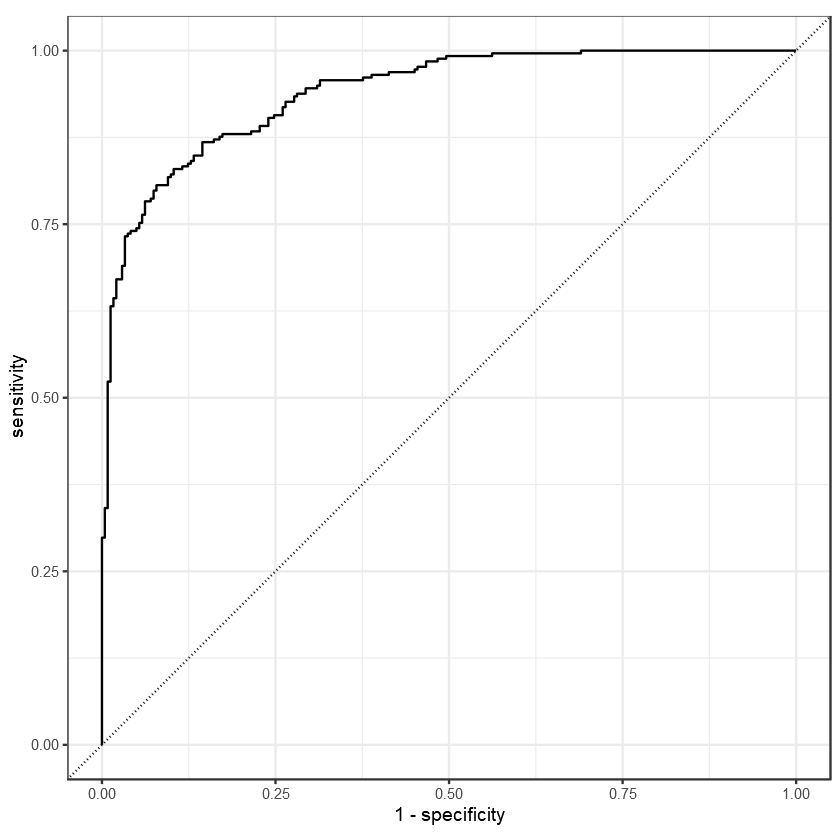

In [95]:
two_class_curve <- roc_curve(two_class_example, truth, Class1)
two_class_curve %>% head()
roc_auc(two_class_example, truth, Class1)
autoplot(two_class_curve)

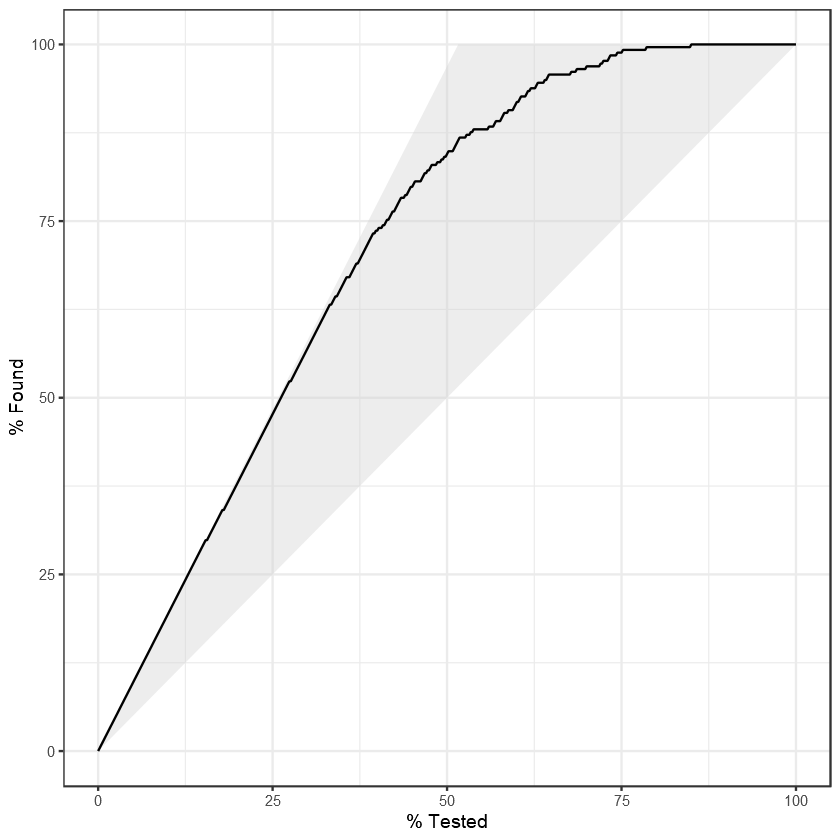

In [92]:
two_class_curve2 <- gain_curve(two_class_example, truth, Class1)
autoplot(two_class_curve2)

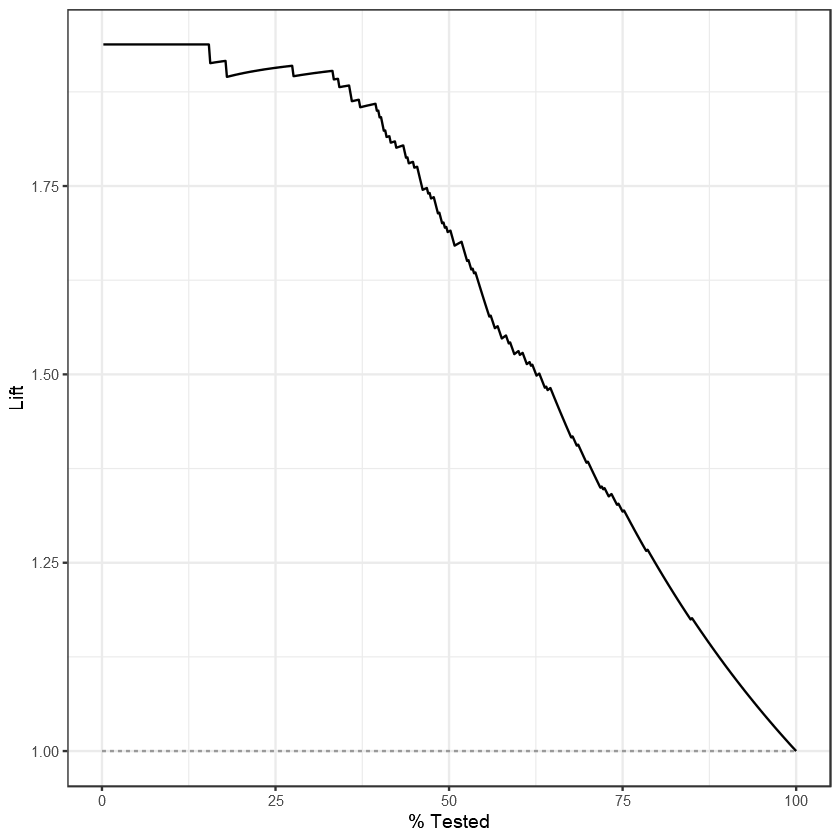

In [93]:
two_class_curve3 <- lift_curve(two_class_example, truth, Class1)
autoplot(two_class_curve3)

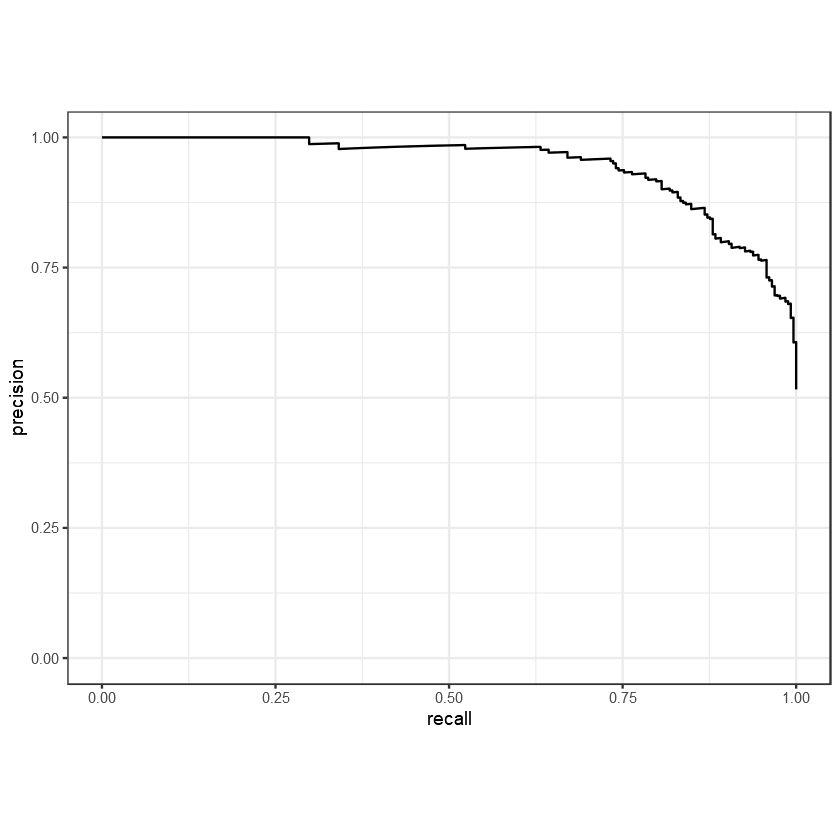

In [94]:
two_class_curve4 <- pr_curve(two_class_example, truth, Class1)
autoplot(two_class_curve4)

# 
# 
# 
## 다지 분류 평가 척도
https://rython.tistory.com/14

In [118]:
data(hpc_cv)
hpc_cv %>% glimpse

Rows: 3,467
Columns: 7
$ obs      <fct> VF, VF, VF, VF, VF, VF, VF, VF, VF, VF, VF, VF, VF, VF, VF, V~
$ pred     <fct> VF, VF, VF, VF, VF, VF, VF, VF, VF, VF, F, F, VF, VF, VF, VF,~
$ VF       <dbl> 0.9136340, 0.9380672, 0.9473710, 0.9289077, 0.9418764, 0.9510~
$ F        <dbl> 0.07786694, 0.05710623, 0.04946767, 0.06528949, 0.05430830, 0~
$ M        <dbl> 0.0084791470, 0.0048164471, 0.0031562870, 0.0057871789, 0.003~
$ L        <dbl> 1.991225e-05, 1.011557e-05, 4.999849e-06, 1.564496e-05, 7.294~
$ Resample <chr> "Fold01", "Fold01", "Fold01", "Fold01", "Fold01", "Fold01", "~


In [97]:
accuracy(hpc_cv, obs, pred)
mcc(hpc_cv, obs, pred)

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.7086819


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
mcc,multiclass,0.5153081


# 
# 
# 



# 



### Micro Average
-  Micro Average는 각각의 TP, FN, FP, TN값들을 모두 합친 total TP, total FN, total FP, total TN값들을 이용해 계산

$\text{TP}_{\text{total}}=\sum^{c}_{i=1}\text{TP}_{i}\\\text{FN}_{\text{total}}=\sum^{c}_{i=1}\text{FN}_{i}\\\text{FP}_{\text{total}}=\sum^{c}_{i=1}\text{FP}_{i}\\\text{TN}_{\text{total}}=\sum^{c}_{i=1}\text{TN}_{i}$

-  Accuracy, Sensitivity, Specificity, False Alarm rate, Precision, F score들을 total 값들을 이용해서 계산
$\text{Accuracy}=\text{Precision}=\text{Sensitivity}=\text{F1 score}$ 가 성립

# 

### Macro Average
-  Micro Average는 각각을 합친 후 계산하는 것으로 생각해본다면 Macro Average는 계산 후 합치는 것으로 생각해볼 수 있습니다. 즉 각각의 class에 따라 TP, FN, FP, TN값들을 이용해서 평가 지표를 계산한 후 그 값들의 평균을 사용

$\text{Sensitivity}=\frac{1}{c}\sum^{c}_{i=1}\text{Sensitivity}_{i}=\frac{1}{c}\sum^{c}_{i=1}\frac{\text{TP}_{i}}{\text{TP}_{i}+\text{FN}_{i}}$

# 

### Macro Weighted Average
-  Macro Average의 확장 Weighted Average
- 그냥 평균을 계산하는 것이 아니라 각 class에 해당하는 data의 개수에 가중치를 주어 평균을 구한 것
- 전체 data 중 class i에 속하는 data 개수의 비율을 p(i)로 생각한다면 Sensitivity의 식은 $\text{Sensitivity}=\sum^{c}_{i=1}p(i)\text{Sensitivity}_{i}=\sum^{c}_{i=1}p(i)\frac{\text{TP}_{i}}{\text{TP}_{i}+\text{FN}_{i}}$

In [106]:
(class_totals <- 
    count(hpc_cv, obs, name = "totals") %>% 
    mutate(class_wts = totals / sum(totals)))

cell_counts <- 
    hpc_cv %>% 
    group_by(obs, pred) %>% 
    count() %>% 
    ungroup()

(one_versus_all <- 
    cell_counts %>% 
    filter(obs == pred) %>% 
    full_join(class_totals, by = "obs") %>% 
    mutate(sens = n / totals))

one_versus_all %>% 
  summarize(
    macro = mean(sens), 
    macro_wts = weighted.mean(sens, class_wts),
    micro = sum(n) / sum(totals)
  )

obs,totals,class_wts
<fct>,<int>,<dbl>
VF,1769,0.51023940
F,1078,0.31093164
M,412,0.11883473
L,208,0.05999423


obs,pred,n,totals,class_wts,sens
<fct>,<fct>,<int>,<int>,<dbl>,<dbl>
VF,VF,1620,1769,0.51023940,0.9157716
F,F,647,1078,0.31093164,0.6001855
M,M,79,412,0.11883473,0.1917476
L,L,111,208,0.05999423,0.5336538


macro,macro_wts,micro
<dbl>,<dbl>,<dbl>
0.5603396,0.7086819,0.7086819


# 
# 
### ```sensitivity()``` : 민감도
- ```estimator``` : ```macro``` / ```macro_weighted``` / ```micro```

In [107]:
sensitivity(hpc_cv, obs, pred, estimator = "macro")
sensitivity(hpc_cv, obs, pred, estimator = "macro_weighted")
sensitivity(hpc_cv, obs, pred, estimator = "micro")

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
sensitivity,macro,0.5603396


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
sensitivity,macro_weighted,0.7086819


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
sensitivity,micro,0.7086819


# 
# 
# 

### AUC

In [116]:
roc_auc(hpc_cv, obs, VF, F, M, L, estimator = "macro_weighted")
roc_auc(hpc_cv, obs, VF, F, M, L, estimator = "macro")
roc_auc(hpc_cv, obs, VF, F, M, L)

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
roc_auc,macro_weighted,0.8683179


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
roc_auc,macro,0.8692636


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
roc_auc,hand_till,0.8288675


In [111]:
hpc_cv %>% 
  group_by(Resample) %>% 
  accuracy(obs, pred)

Resample,.metric,.estimator,.estimate
<chr>,<chr>,<chr>,<dbl>
Fold01,accuracy,multiclass,0.7262248
Fold02,accuracy,multiclass,0.7118156
Fold03,accuracy,multiclass,0.7579251
Fold04,accuracy,multiclass,0.7118156
Fold05,accuracy,multiclass,0.7118156
Fold06,accuracy,multiclass,0.6974063
Fold07,accuracy,multiclass,0.6753623
Fold08,accuracy,multiclass,0.7212644
Fold09,accuracy,multiclass,0.6734104


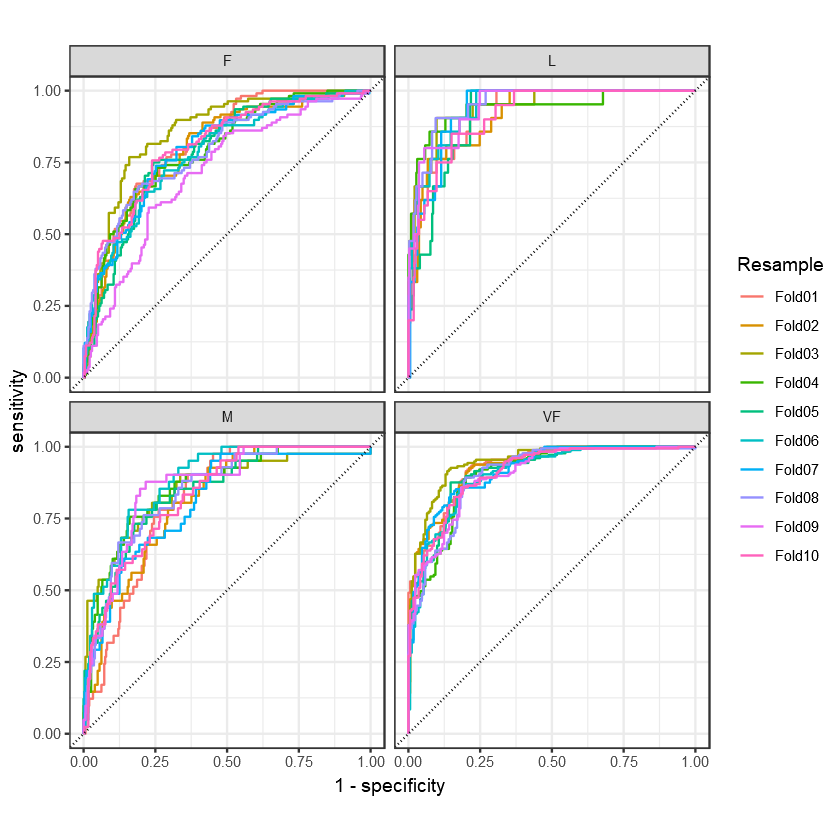

In [112]:
hpc_cv %>% 
  group_by(Resample) %>% 
  roc_curve(obs, VF, F, M, L) %>% 
  autoplot()